In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np
from astropy.io import fits

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import matplotlib.pyplot as plt

from bliss.surveys.des import DarkEnergySurvey, DESDownloader

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

In [83]:
environ["CUDA_VISIBLE_DEVICES"] = "4"

In [84]:
with initialize(config_path="../", version_base=None):
    cfg = compose("config", {
        "encoder.tiles_to_crop=0",
        })

In [85]:
cfg.predict

{'dataset': '${surveys.des}', 'trainer': {'_target_': 'pytorch_lightning.Trainer', 'accelerator': 'gpu', 'precision': '${train.trainer.precision}'}, 'encoder': '${encoder}', 'weight_save_path': '${paths.output}/version_1/checkpoints/best_encoder.ckpt', 'device': 'cuda:0'}

In [86]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
#dataset = instantiate(cfg.cached_simulator)
#trainer = instantiate(cfg.predict.trainer)

<All keys matched successfully>

In [87]:
cfg.predict.encoder

{'_target_': 'case_studies.galaxy_clustering.encoder.encoder.GalaxyClusterEncoder', 'survey_bands': ['g', 'r', 'i', 'z'], 'tile_slen': '${simulator.prior.tile_slen}', 'tiles_to_crop': 0, 'min_flux_for_loss': 0, 'min_flux_for_metrics': 0, 'optimizer_params': {'lr': 0.001}, 'scheduler_params': {'milestones': [32], 'gamma': 0.1}, 'image_normalizer': {'_target_': 'bliss.encoder.image_normalizer.ImageNormalizer', 'bands': [0, 1, 2, 3], 'include_original': True, 'include_background': False, 'concat_psf_params': False, 'num_psf_params': 6, 'log_transform_stdevs': None, 'use_clahe': False, 'clahe_min_stdev': None}, 'var_dist': {'_target_': 'case_studies.galaxy_clustering.encoder.variational_dist.GalaxyClusterVariationalDist', 'tile_slen': '${encoder.tile_slen}', 'factors': '${variational_factors}'}, 'matcher': {'_target_': 'bliss.encoder.metrics.CatalogMatcher', 'dist_slack': 1.0, 'mag_slack': None, 'mag_band': 2}, 'metrics': {'_target_': 'torchmetrics.MetricCollection', '_convert_': 'partial'

In [94]:
def create_overlay(predictions, tile_size):
    overlay = torch.zeros((predictions.size(0) * tile_size, predictions.size(1) * tile_size, 3))
    detection_color = torch.tensor([0.0, 1.0, 0.0])  # Green color
    non_detection_color = torch.tensor([1.0, 0.0, 0.0])  # Red color
    for i in range(predictions.size(0)):
        for j in range(predictions.size(1)):
            color = detection_color if predictions[i, j] == 1 else non_detection_color
            overlay[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = color
    return overlay

def blend_images(original, overlay, alpha=0.5, img_crop=0):
    # Ensure the original image is in float
    if original.max() > 1.0:
        original = original / 255.0
    # Blend the images
    blended = original * (1 - alpha) + overlay * alpha
    blended = blended[img_crop: blended.size(0) - img_crop, img_crop: blended.size(1) - img_crop]
    print(blended.shape)
    return blended

def compute_metrics(est_cat, true_cat):
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    false_positives = (est_cat & ~true_cat).sum(dtype=torch.float32)
    false_negatives = (~est_cat & true_cat).sum(dtype=torch.float32)
    true_negatives = (~est_cat & ~true_cat).sum(dtype=torch.float32)

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives + 1e-6)  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), f1.item()
    

# Experiment 1

In [8]:
image_g = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/9.99503_-37.71075_g.fits")[500:1780, 500:1780]
image_r = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/9.99503_-37.71075_g.fits")[500:1780, 500:1780]
image_i = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/9.99503_-37.71075_g.fits")[500:1780, 500:1780]
image_z = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/9.99503_-37.71075_g.fits")[500:1780, 500:1780]

In [9]:
image_full = torch.tensor(np.stack([image_g, image_r, image_i, image_z])).unsqueeze(0).unsqueeze(2)
x = encoder.features_net(image_full)
x_cat = encoder.marginal_net(x)
marginal_cat = encoder.var_dist.sample(x_cat, use_mode=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1280, 1280, 3])


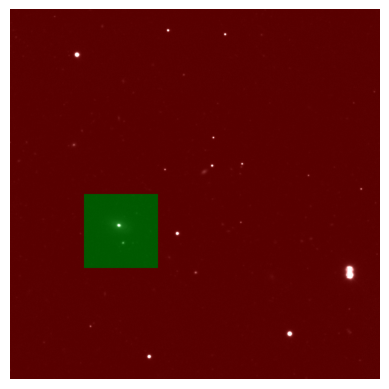

In [80]:
test_img = image_full[0,0:3,0,:,:]
test_out = marginal_cat["membership"].squeeze()
overlay = create_overlay(test_out, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()

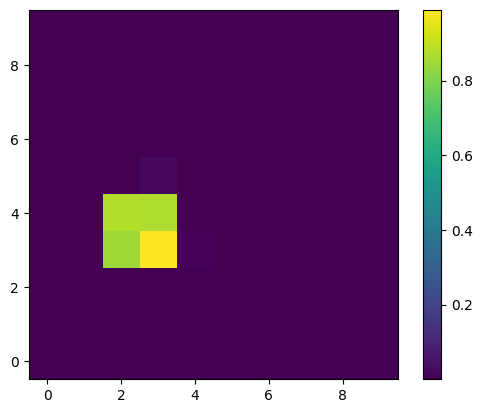

In [60]:
prob = x_cat.sigmoid().clamp(1e-4, 1 - 1e-4)[0].squeeze().detach().numpy()
plt.imshow(prob, origin="lower")
plt.colorbar()

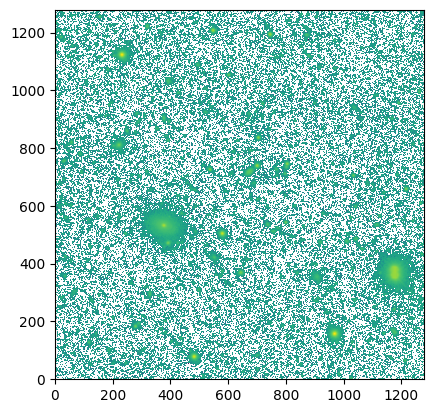

In [61]:
from matplotlib.colors import LogNorm
plt.imshow(image_full[0,0,0,:,:], norm=LogNorm(), origin="lower")

# Experiment 2

In [88]:
image_g = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/6.62503_-41.86096_g.fits")[500:1780, 500:1780]
image_r = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/6.62503_-41.86096_r.fits")[500:1780, 500:1780]
image_i = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/6.62503_-41.86096_i.fits")[500:1780, 500:1780]
image_z = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/6.62503_-41.86096_z.fits")[500:1780, 500:1780]

In [89]:
image_full = torch.tensor(np.stack([image_g, image_r, image_i, image_z])).unsqueeze(0).unsqueeze(2)
x = encoder.features_net(image_full)
x_cat = encoder.marginal_net(x)
marginal_cat = encoder.var_dist.sample(x_cat, use_mode=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1280, 1280, 3])


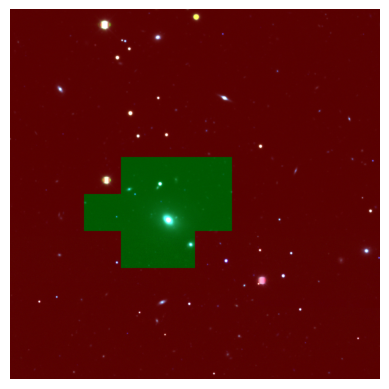

In [90]:
test_img = image_full[0,0:3,0,:,:]
test_out = marginal_cat["membership"].squeeze()
overlay = create_overlay(test_out, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()

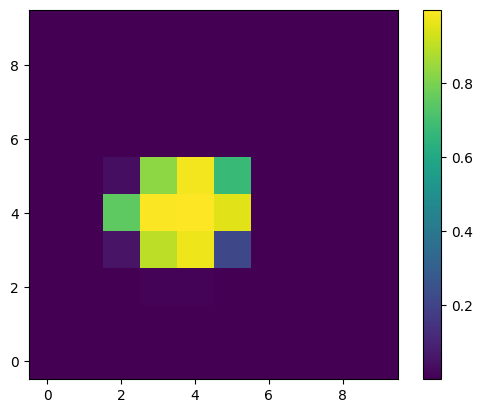

In [91]:
prob = x_cat.sigmoid().clamp(1e-4, 1 - 1e-4)[0].squeeze().detach().numpy()
plt.imshow(prob, origin="lower")
plt.colorbar()

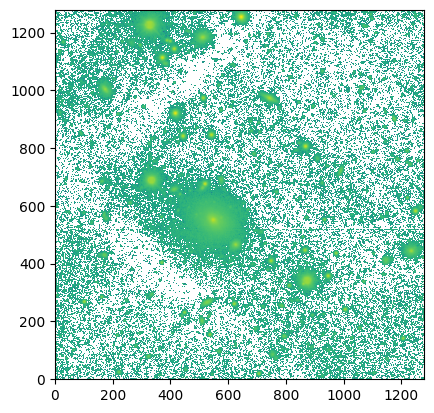

In [92]:
from matplotlib.colors import LogNorm
plt.imshow(image_full[0,0,0,:,:], norm=LogNorm(), origin="lower")

# Experiment 3

In [98]:
image_g = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/2.95916_-48.24259_g.fits")[1270:, 0:1280]
image_r = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/2.95916_-48.24259_r.fits")[1270:, 0:1280]
image_i = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/2.95916_-48.24259_i.fits")[1270:, 0:1280]
image_z = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/2.95916_-48.24259_z.fits")[1270:, 0:1280]

In [99]:
image_full = torch.tensor(np.stack([image_g, image_r, image_i, image_z])).unsqueeze(0).unsqueeze(2)
x = encoder.features_net(image_full)
x_cat = encoder.marginal_net(x)
marginal_cat = encoder.var_dist.sample(x_cat, use_mode=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1280, 1280, 3])


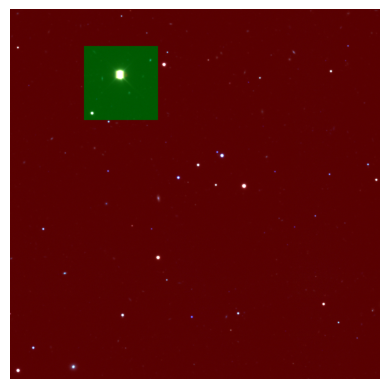

In [100]:
test_img = image_full[0,0:3,0,:,:]
test_out = marginal_cat["membership"].squeeze()
overlay = create_overlay(test_out, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()

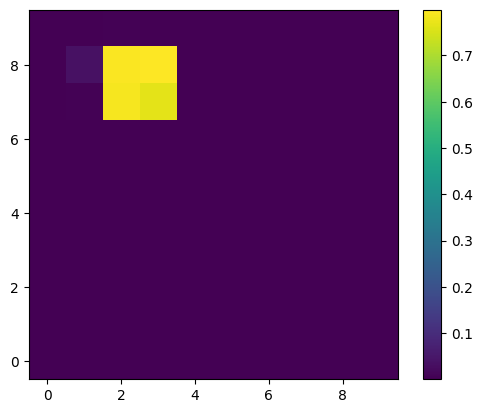

In [101]:
prob = x_cat.sigmoid().clamp(1e-4, 1 - 1e-4)[0].squeeze().detach().numpy()
plt.imshow(prob, origin="lower")
plt.colorbar()

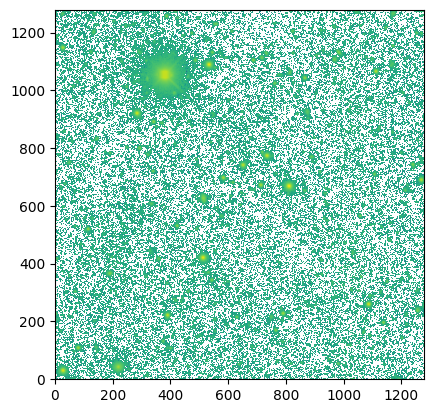

In [102]:
from matplotlib.colors import LogNorm
plt.imshow(image_full[0,0,0,:,:], norm=LogNorm(), origin="lower")

# Experiment 4

In [103]:
image_g = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/7.98499_-1.99208_g.fits")[0:1280, 1000:2280]
image_r = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/7.98499_-1.99208_g.fits")[0:1280, 1000:2280]
image_i = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/7.98499_-1.99208_g.fits")[0:1280, 1000:2280]
image_z = fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/DES_images/7.98499_-1.99208_g.fits")[0:1280, 1000:2280]

In [104]:
image_full = torch.tensor(np.stack([image_g, image_r, image_i, image_z])).unsqueeze(0).unsqueeze(2)
x = encoder.features_net(image_full)
x_cat = encoder.marginal_net(x)
marginal_cat = encoder.var_dist.sample(x_cat, use_mode=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1280, 1280, 3])


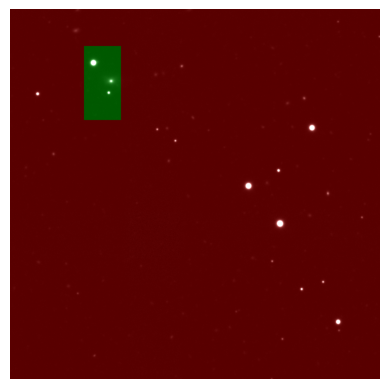

In [105]:
test_img = image_full[0,0:3,0,:,:]
test_out = marginal_cat["membership"].squeeze()
overlay = create_overlay(test_out, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()

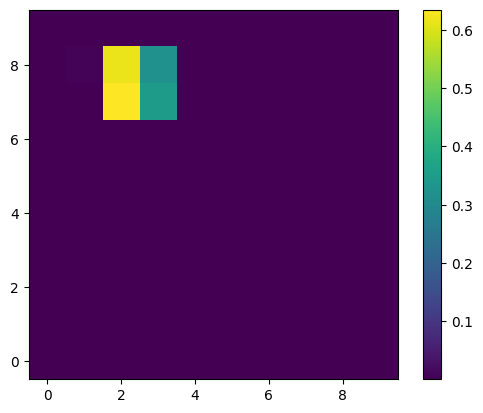

In [106]:
prob = x_cat.sigmoid().clamp(1e-4, 1 - 1e-4)[0].squeeze().detach().numpy()
plt.imshow(prob, origin="lower")
plt.colorbar()

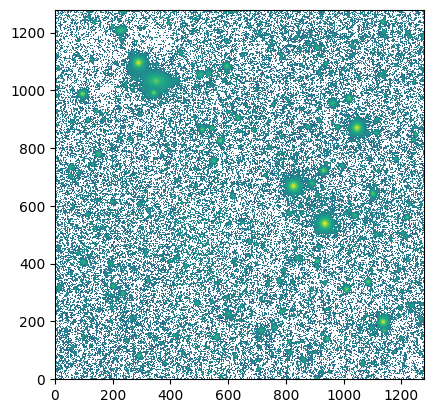

In [107]:
from matplotlib.colors import LogNorm
plt.imshow(image_full[0,0,0,:,:], norm=LogNorm(), origin="lower")